## Speed dating data-set
#### Joris Rombouts - November 2017

### 1.3 Feature Engineering

### <font color="green">imports, preparation and configuration</font>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree, preprocessing, metrics
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# imports needed for the visualization and exportation of visualizations
import graphviz as gv # not included in the standard anaconda installer (can be found in the Anaconda Navigator)
import pydotplus # not included in anaconda at all (use pip/conda install pydotplus in cmd/conda prompt etc)
import io
from scipy import misc

In [3]:
df = pd.read_csv("speed_dating_assignment.csv")
df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


The model should be trained to build the class attribute <i>dec</i>. To help and improve the models, one can introduce new (calculated) features. These features should optimize the performance metric. Just as in 1.2, the attributes with a lot of missing values (NaN) are not very usefull for the model. Because this is a small size of dataset, the NaN values won't be filled in. 
This improved model is built on the model of 1.2, with some extra new calculated features. For introducing new calculated features, the attributes of the partner need to be accessed by cross-referencing it (using <i>pid == iid </i>. In addition to the attributes that are used in 1.2, the following features are added to the dataframe:

* <b>age_diff</b> <i>absolute difference between subject's age and partners age (age_o, see 1.1)</i> 
* <b>attr_o</b> <i>rating by partner the night of the event, for all six attributes (attr,sinc,intel,fun,amb and shar)</i>
* <b>race_equals</b> <i>boolean value, which is True if the race of the partner equals the race of the participant and False otherwise</i>
* <b>goal_equals</b> <i>boolean value, which is True if the goal of the partner equals the goal of the participant and False otherwise </i>

In [4]:
df_o = df.copy()
df_o = df_o.filter(items=['iid', 'age', 'race', 'goal'])
df_o.rename(columns={'iid': 'pid', 'age': 'age_o', 'race': 'race_partner', 'goal':'goal_partner'}, inplace = True)
df_o = df_o.drop_duplicates()

df_new = pd.merge(df, df_o, on=['pid'], how = 'left')

In [5]:
df =df_new.copy()

In [6]:
df_new = df[(df['wave'] >= 6) & (df['wave'] <= 9)]
df_new.shape

(1562, 178)

In [7]:
df = pd.concat([df, df_new, df_new]).drop_duplicates(keep=False)
df.shape

(6816, 178)

In [8]:
df = df[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'gender', 'order','goal', 'field_cd', 'date','age', 'go_out', 'imprace', 'imprelig', 'dec', 'age_o', 'race', 'pid', 'iid', 'race_partner', 'goal_partner']]
df.age.fillna(df.age.median(), inplace = True)
df.head()

,attr,sinc,intel,fun,amb,shar,gender,order,goal,field_cd,...,go_out,imprace,imprelig,dec,age_o,race,pid,iid,race_partner,goal_partner
0,6.0,9.0,7.0,7.0,6.0,5.0,0,4,2.0,1.0,...,1.0,2.0,4.0,1,27.0,4.0,11,1,2.0,1.0
1,7.0,8.0,7.0,8.0,5.0,6.0,0,3,2.0,1.0,...,1.0,2.0,4.0,1,22.0,4.0,12,1,2.0,1.0
2,5.0,8.0,9.0,8.0,5.0,7.0,0,10,2.0,1.0,...,1.0,2.0,4.0,1,22.0,4.0,13,1,4.0,2.0
3,7.0,6.0,8.0,7.0,6.0,8.0,0,5,2.0,1.0,...,1.0,2.0,4.0,1,23.0,4.0,14,1,2.0,2.0
4,5.0,6.0,7.0,7.0,6.0,6.0,0,7,2.0,1.0,...,1.0,2.0,4.0,1,24.0,4.0,15,1,3.0,1.0


In [9]:
df = df.dropna().reset_index(drop=True)

### <font color="green">Calculating new features</font>

In [10]:
df['attr_o'] = df['attr'] + df['sinc'] + df['intel'] + df['fun'] + df['amb'] + df['shar']
df = df.drop(['attr', 'sinc', 'intel', 'fun', 'shar', 'amb'], axis = 1)

In [11]:
df['age_diff'] = abs(df['age'] - df['age_o'])

In [12]:
df['race_equals'] = (df['race'] == df['race_partner'])

In [13]:
df['goal_equals'] = df.apply(lambda r: r.goal == r.goal_partner, axis = 1)

In [14]:
df = df[['gender', 'order','goal', 'field_cd', 'date','age', 'go_out', 'imprace', 'imprelig', 'dec','age_diff', 'attr_o','race_equals', 'goal_equals']]
df.head()

,gender,order,goal,field_cd,date,age,go_out,imprace,imprelig,dec,age_diff,attr_o,race_equals,goal_equals
0,0,4,2.0,1.0,7.0,21.0,1.0,2.0,4.0,1,6.0,40.0,False,False
1,0,3,2.0,1.0,7.0,21.0,1.0,2.0,4.0,1,1.0,41.0,False,False
2,0,10,2.0,1.0,7.0,21.0,1.0,2.0,4.0,1,1.0,42.0,True,True
3,0,5,2.0,1.0,7.0,21.0,1.0,2.0,4.0,1,2.0,42.0,False,True
4,0,7,2.0,1.0,7.0,21.0,1.0,2.0,4.0,1,3.0,37.0,False,False


### <font color="green">Training the models</font>

In [15]:
male_subjects = df[df.gender == 1]
female_subjects = df[df.gender == 0]
male_subjects.shape, female_subjects.shape

((2775, 14), (2784, 14))

In [16]:
male_subjects_shuffle = male_subjects.sample(frac=1).reset_index(drop=True) # shuffle rows
female_subjects_shuffle = female_subjects.sample(frac=1).reset_index(drop=True)

In [17]:
male_x_data = male_subjects_shuffle.drop('dec', axis = 1) # dec is target attribute
female_x_data = female_subjects_shuffle.drop('dec', axis = 1)
male_labels = male_subjects_shuffle['dec']
female_labels = female_subjects_shuffle['dec']

In [18]:
male_x_train, male_x_test, male_y_train, male_y_test = train_test_split(male_x_data, male_labels, test_size = 0.2)
female_x_train, female_x_test, female_y_train, female_y_test = train_test_split(female_x_data, female_labels, test_size = 0.2)

In [19]:
dec_tree_male = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 8, min_samples_split = 50, min_samples_leaf = 12)
dec_tree_female = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 8, min_samples_split = 50, min_samples_leaf = 12)
# build decision tree classifiers from the training sets
dec_tree_male.fit(male_x_train, male_y_train)
dec_tree_female.fit(female_x_train, female_y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=12, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### <font color="green">Visualizing the models</font>

In [20]:
def visualize_tree(dec_tree, path, classnames, feat_names):
    dfile = io.StringIO()
    tree.export_graphviz(dec_tree, out_file = dfile, feature_names = feat_names)
    pydotplus.graph_from_dot_data(dfile.getvalue()).write_png(path)
    i = misc.imread(path)
    plt.imshow(i)

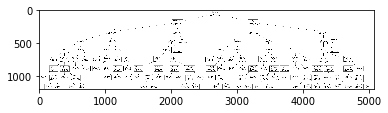

In [21]:
male_col_names = dec_tree_male.classes_
male_feature_names = male_subjects.columns[0:(male_subjects.shape[1] - 1)] # the features (attributes) used in the model
visualize_tree(dec_tree_male, "male_decision_tree(1.3).png", male_col_names, male_feature_names)

See Appendix A.3 for the full image (uncropped)

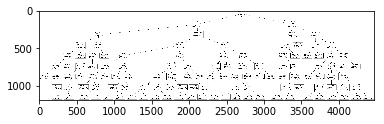

In [22]:
female_col_names = dec_tree_female.classes_
female_feature_names = female_subjects.columns[0:(female_subjects.shape[1] - 1)] # the features (attributes) used in the model
visualize_tree(dec_tree_female, "female_decision_tree(1.3).png", female_col_names, female_feature_names)

See Appendix A.4 for the full image (uncropped)

### <font color="green">Evaluating the performance of the models</font>

In [23]:
pred_male = dec_tree_male.predict(male_x_test) # predicting 'dec' for data which the model has not seen yet
print("Accuracy score: ", metrics.accuracy_score(male_y_test, pred_male))

Accuracy score:  0.704504504505


In [24]:
pred_female = dec_tree_female.predict(female_x_test) # predicting 'dec' for data which the model has not seen yet
print("Accuracy score: ", metrics.accuracy_score(female_y_test, pred_female))

Accuracy score:  0.748653500898


In [25]:
print(metrics.classification_report(male_y_test, pred_male))

             precision    recall  f1-score   support

          0       0.70      0.75      0.72       285
          1       0.71      0.66      0.68       270

avg / total       0.71      0.70      0.70       555



In [26]:
print(metrics.classification_report(female_y_test, pred_female))

             precision    recall  f1-score   support

          0       0.81      0.80      0.80       360
          1       0.64      0.65      0.65       197

avg / total       0.75      0.75      0.75       557



### <font color="green">Comparing the differences among the models</font>